In [30]:
from utils.dataframe import read_final_csv

df = read_final_csv("boosting_model")

In [31]:
from utils.dataframe import delete_columns

last_n_matches = [5, 10, 20, 50]
df = delete_columns(df, last_n_matches)

In [32]:
correlations = df.corr(numeric_only=True)['player_1_won'].drop('player_1_won')
sorted_corrs = correlations.abs().sort_values(ascending=False)

strongest_corrs = correlations.loc[sorted_corrs.index]
print(strongest_corrs)

elo_diff                  0.374787
elo_surface_diff          0.357317
last_20_win_ratio_diff    0.325704
last_20_match_won_diff    0.325704
last_10_win_ratio_diff    0.318537
                            ...   
surface_Clay             -0.000844
player_1_entry_Alt       -0.000842
tourney_month             0.000507
tourney_level_D           0.000154
player_2_entry_SE        -0.000016
Name: player_1_won, Length: 136, dtype: float64


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95375 entries, 0 to 95374
Columns: 137 entries, player_1_entry_ALT to player_1_won
dtypes: bool(28), float64(98), int64(11)
memory usage: 81.9 MB


In [34]:
split_year = 2022

x_train = df[df["tourney_year"] < split_year].drop("player_1_won", axis=1)
y_train = df[df["tourney_year"] < split_year]["player_1_won"]

x_test = df[df["tourney_year"] >= split_year].drop("player_1_won", axis=1)
y_test = df[df["tourney_year"] >= split_year]["player_1_won"]

In [39]:
x_train.tail()

,player_1_entry_ALT,player_1_entry_Alt,player_1_entry_LL,player_1_entry_PR,player_1_entry_Q,player_1_entry_SE,player_1_entry_WC,player_1_hand_L,player_1_hand_R,player_2_entry_ALT,...,last_5_win_ratio_diff,last_10_win_ratio_diff,last_20_win_ratio_diff,last_50_win_ratio_diff,elo_diff,last_5_elo_progress_diff,last_10_elo_progress_diff,last_20_elo_progress_diff,last_50_elo_progress_diff,draw_size
86891,False,False,False,False,False,False,False,False,True,False,...,-0.4,-0.2,-0.10,-0.04,-410.048681,-0.004253,0.015425,0.001138,0.032805,2.0
86892,False,False,False,False,False,False,False,False,True,False,...,0.2,0.6,0.80,0.92,193.823219,-0.028676,-0.042889,-0.080891,-0.152293,2.0
86893,False,False,False,False,False,False,False,False,True,False,...,0.6,0.8,0.65,0.86,392.190788,0.008309,-0.006669,0.049812,0.048016,2.0
86894,False,False,False,False,False,False,False,False,True,False,...,0.0,-0.5,-0.75,-0.90,-293.499053,0.019730,0.031225,0.065317,0.086457,2.0
86895,False,False,False,False,False,False,False,False,True,False,...,-0.6,-0.3,-0.15,-0.06,-294.723655,-0.017238,0.000855,-0.016165,0.020251,2.0


In [36]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42,
                                n_estimators=150,
                                class_weight="balanced")

forest.fit(x_train, y_train)

,n_estimators,150
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

forest_pred = forest.predict(x_test)
forest_proba = forest.predict_proba(x_test)[:, 1]

forest_acc = accuracy_score(y_test, forest_pred)
forest_auc = roc_auc_score(y_test, forest_proba)
forest_logloss = log_loss(y_test, forest_proba)

print("Random Forest Model Performance:")
print(f"Random Forest Accuracy: {forest_acc * 100:.2f}%")
print(f"ROC AUC: {forest_auc:.2f}")
print(f"Log Loss: {forest_logloss:2f}")

Catboost Model Performance:
Catboost Accuracy: 65.70%
ROC AUC: 0.72
Log Loss: 0.615112


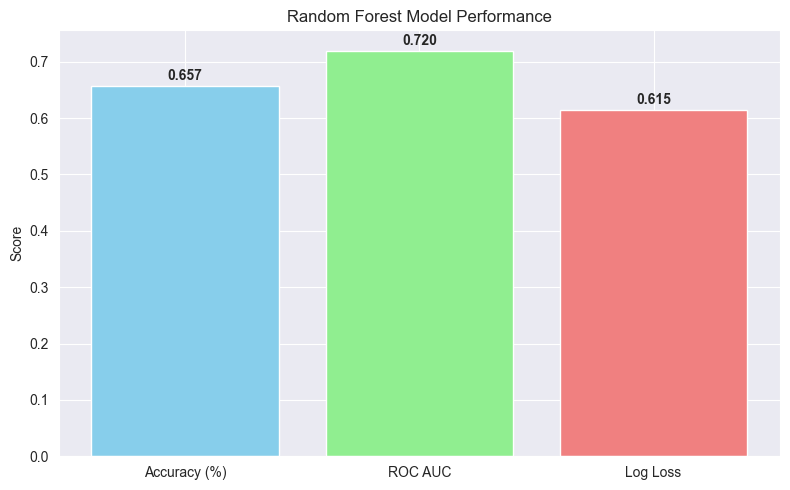

In [41]:
import matplotlib.pyplot as plt

metrics = ['Accuracy (%)', 'ROC AUC', 'Log Loss']
values = [forest_acc, forest_auc, forest_logloss]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Random Forest Model Performance')
plt.ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [42]:
importances = forest.feature_importances_
feature_names = x_train.columns
importance_list = [[feature, importance] for feature, importance in
                   zip(feature_names, importances)]

importance_list.sort(key=lambda x: x[1], reverse=True)
for feature, importance in importance_list:
    print(f"{feature}: {importance * 100}%")

elo_diff: 3.484282554334513%
elo_surface_diff: 2.9521142122390427%
rank_points_diff: 2.302901567180264%
rank_diff: 2.3002476928269795%
original_rank_diff: 2.2373035890275204%
win_ratio_diff: 1.8257033257834565%
age_diff: 1.4658397898442745%
last_20_win_ratio_diff: 1.2704076894232208%
last_5_elo_progress_diff: 1.0759138579137189%
last_50_elo_progress_diff: 1.052732267311296%
last_20_match_won_diff: 1.0525459555963619%
last_10_elo_progress_diff: 1.0505633178965836%
last_20_elo_progress_diff: 1.0264586979127959%
last_10_win_ratio_diff: 1.0056524109381506%
last_50_win_ratio_diff: 0.9836933634859333%
1stWon_last_50_surface_diff: 0.973701616357775%
1stWon_last_5_diff: 0.9383387200557061%
last_10_match_won_diff: 0.9262846516551803%
1stWon_total_diff: 0.9070169948673634%
won_match_diff: 0.8878197769075212%
2ndWon_last_50_surface_diff: 0.882147567540195%
2ndWon_last_20_surface_diff: 0.8716415116176703%
2ndWon_last_5_diff: 0.8707481182619196%
svpt_last_5_surface_diff: 0.8606745509432425%
2ndWon_

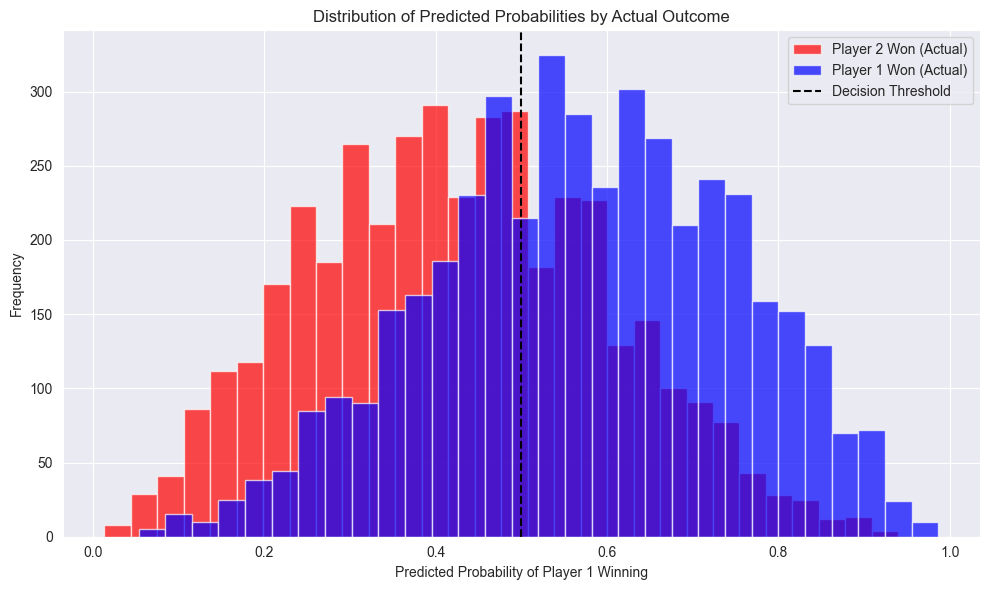

In [43]:
import matplotlib.pyplot as plt

y_pred_proba = forest.predict_proba(x_test)[:, 1]

plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='Player 2 Won (Actual)', color='red')
plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Player 1 Won (Actual)', color='blue')

plt.axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold')
plt.xlabel('Predicted Probability of Player 1 Winning')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities by Actual Outcome')

plt.legend()
plt.tight_layout()
plt.show()

In [44]:
final_split_year = 2024

x_final_train = df[df["tourney_year"] <= final_split_year].drop("player_1_won", axis=1)
y_final_train = df[df["tourney_year"] <= final_split_year]["player_1_won"]

In [45]:
from sklearn.ensemble import RandomForestClassifier

final_forest = RandomForestClassifier(random_state=42,
                                n_estimators=150,
                                class_weight="balanced")

final_forest.fit(x_final_train, y_final_train)

,n_estimators,150
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [46]:
import joblib

from config import ROOT_DIR

joblib.dump(final_forest, f"{ROOT_DIR}/models/random_forest.joblib")

['C:\\Users\\hikme\\Desktop\\Programming Projects\\Personal Projects\\AI Proejcts\\tennis-ai/models/random_forest.joblib']